<a href="https://colab.research.google.com/github/yihaozhong/Mining-Massive-Data-Sets/blob/main/CS246_Colab_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS246 - Colab 0
## Spark Tutorial

In this tutorial you will learn how to use [Apache Spark](https://spark.apache.org) in local mode on a Colab enviroment.

Credits to [Tiziano Piccardi](http://piccardi.me/) for his Spark Tutorial used in the Applied Data Analysis class at EPFL.

### Setup

Let's setup Spark on your Colab environment.  Run the cell below!

In [8]:
!pip install pyspark
!pip install -U -q PyDrive2
#the output 'xxx is not a symbolic link' will not affect your implementation or execution
#to fix 'xxx is not a symbolic link', you can uncomment the lines starting from !mv xxxx
#you may need to replace xxx.11 with the correct version if other errors come up after colab update
#to get the correct version, use !ls /usr/local/lib to find out
!mv /usr/local/lib/libtbbmalloc_proxy.so.2 /usr/local/lib/libtbbmalloc_proxy.so.2.backup
!mv /usr/local/lib/libtbbmalloc.so.2 /usr/local/lib/libtbbmalloc.so.2.backup
!mv /usr/local/lib/libtbbbind_2_5.so.3 /usr/local/lib/libtbbbind_2_5.so.3.backup
!mv /usr/local/lib/libtbb.so.12 /usr/local/lib/libtbb.so.12.backup
!mv /usr/local/lib/libtbbbind_2_0.so.3 /usr/local/lib/libtbbbind_2_0.so.3.backup
!mv /usr/local/lib/libtbbbind.so.3 /usr/local/lib/libtbbbind.so.3.backup
!ln -s /usr/local/lib/libtbbmalloc_proxy.so.2.11 /usr/local/lib/libtbbmalloc_proxy.so.2
!ln -s /usr/local/lib/libtbbmalloc.so.2.11 /usr/local/lib/libtbbmalloc.so.2
!ln -s /usr/local/lib/libtbbbind_2_5.so.3.11 /usr/local/lib/libtbbbind_2_5.so.3
!ln -s /usr/local/lib/libtbb.so.12.11 /usr/local/lib/libtbb.so.12
!ln -s /usr/local/lib/libtbbbind_2_0.so.3.11 /usr/local/lib/libtbbbind_2_0.so.3
!ln -s /usr/local/lib/libtbbbind.so.3.11 /usr/local/lib/libtbbbind.so.3
#If error related to the above execution occurs, you can try commenting out the above 12 lines under pip install PyDrive2 (not included)

# !sudo ldconfig
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"


openjdk-8-jdk-headless is already the newest version (8u472-ga-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


Now we authenticate a Google Drive client to download the file we will be processing in our Spark job.

**Make sure to follow the interactive instructions.**

In [9]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [10]:
id='1L6pCQkldvdBoaEhRFzL0VnrggEFvqON4'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('Bombing_Operations.json.gz')

id='14dyBmcTBA32uXPxDbqr0bFDIzGxMTWwl'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('Aircraft_Glossary.json.gz')

If you executed the cells above, you should be able to see the files *Bombing_Operations.json.gz* and *Aircraft_Glossary.json.gz* under the "Files" tab on the left panel.

In [11]:
# Let's import the libraries we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Let's initialize the Spark context.


In [12]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [13]:
spark

If you are running this Colab on the Google hosted runtime, the cell below will create a *ngrok* tunnel which will allow you to check the Spark UI.

**This part is not needed for you to get correct result for colab 0, so you can ignore any error and continue.**

**To facilitate setting up the ngrok tunnel, please do the following steps:**
1. First, navigate to the ngrok website and create your account: https://dashboard.ngrok.com/login
2. Then, obtain your authentication token from https://dashboard.ngrok.com/get-started/your-authtoken
3. Replace \<YOUR_AUTH_TOKEN_HERE\> in the following cell with your auth token.

You can then proceed to run the following cells, and you should be able to see the Spark UI as a separate web page. Please access the link of `public_url`.

(If you see a security warning, "Deceptive site ahead", please click "Details -> visit this unsafe site" to view the Spark UI.)

In [14]:
!wget https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
!tar -xvzf ngrok-v3-stable-linux-amd64.tgz
!./ngrok authtoken <> #replace this with your token
!cat ~/.ngrok2/ngrok.yml
get_ipython().system_raw('./ngrok http 4050 &')

--2026-01-15 07:17:56--  https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 99.83.220.108, 13.248.244.96, 35.71.179.82, ...
Connecting to bin.equinox.io (bin.equinox.io)|99.83.220.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11382588 (11M) [application/octet-stream]
Saving to: ‘ngrok-v3-stable-linux-amd64.tgz’

ngrok-v3-stable-lin 100%[===================>]  10.85M  23.6MB/s    in 0.5s    

2026-01-15 07:17:57 (23.6 MB/s) - ‘ngrok-v3-stable-linux-amd64.tgz’ saved [11382588/11382588]

ngrok
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
cat: /root/.ngrok2/ngrok.yml: No such file or directory


In [15]:
!curl -s http://localhost:4040/api/tunnels

{"tunnels":[{"name":"command_line","ID":"c3c48706ea580d0244b966d7d2986118","uri":"/api/tunnels/command_line","public_url":"https://theron-abler-expostulatingly.ngrok-free.dev","proto":"https","config":{"addr":"http://localhost:4050","inspect":true},"metrics":{"conns":{"count":0,"gauge":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0},"http":{"count":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0}}}],"uri":"/api/tunnels"}


# Spark Example

----


**The dataset description.**

**Bombing_Operations** [Get the dataset here](https://drive.google.com/a/epfl.ch/file/d/1L6pCQkldvdBoaEhRFzL0VnrggEFvqON4/view?usp=sharing)

- AirCraft: _Aircraft model (example: EC-47)_
- ContryFlyingMission: _Country_
- MissionDate: _Date of the mission_
- OperationSupported
- PeriodOfDay: _Day or night_
- TakeoffLocation: _Take off airport_
- TimeOnTarget
- WeaponType
- WeaponsLoadedWeight

**Aircraft_Glossary** [Get the dataset here](https://drive.google.com/a/epfl.ch/file/d/14dyBmcTBA32uXPxDbqr0bFDIzGxMTWwl/view?usp=sharing)

- AirCraft: _Aircraft model (example: EC-47)_
- AirCraftName
- AirCraftType


Load the datasets:

In [16]:
Bombing_Operations = spark.read.json("Bombing_Operations.json.gz")
Aircraft_Glossary = spark.read.json("Aircraft_Glossary.json.gz")

Check the schema:

In [17]:
Bombing_Operations.printSchema()

root
 |-- AirCraft: string (nullable = true)
 |-- ContryFlyingMission: string (nullable = true)
 |-- MissionDate: string (nullable = true)
 |-- OperationSupported: string (nullable = true)
 |-- PeriodOfDay: string (nullable = true)
 |-- TakeoffLocation: string (nullable = true)
 |-- TargetCountry: string (nullable = true)
 |-- TimeOnTarget: double (nullable = true)
 |-- WeaponType: string (nullable = true)
 |-- WeaponsLoadedWeight: long (nullable = true)



In [18]:
Aircraft_Glossary.printSchema()

root
 |-- AirCraft: string (nullable = true)
 |-- AirCraftName: string (nullable = true)
 |-- AirCraftType: string (nullable = true)



Get a sample with `take()`:

In [19]:
Bombing_Operations.take(3)

[Row(AirCraft='EC-47', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1971-06-05', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='TAN SON NHUT', TargetCountry='CAMBODIA', TimeOnTarget=1005.0, WeaponType=None, WeaponsLoadedWeight=0),
 Row(AirCraft='EC-47', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1972-12-26', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='NAKHON PHANOM', TargetCountry='SOUTH VIETNAM', TimeOnTarget=530.0, WeaponType=None, WeaponsLoadedWeight=0),
 Row(AirCraft='RF-4', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1973-07-28', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='UDORN AB', TargetCountry='LAOS', TimeOnTarget=730.0, WeaponType=None, WeaponsLoadedWeight=0)]

Get a formatted sample with `show()`:

In [20]:
Aircraft_Glossary.show()

+--------+--------------------+--------------------+
|AirCraft|        AirCraftName|        AirCraftType|
+--------+--------------------+--------------------+
|     A-1|Douglas A-1 Skyra...|         Fighter Jet|
|    A-26|Douglas A-26 Invader|        Light Bomber|
|    A-37|Cessna A-37 Drago...|Light ground-atta...|
|     A-4|McDonnell Douglas...|         Fighter Jet|
|     A-5|North American A-...|          Bomber Jet|
|     A-6|Grumman A-6 Intruder|     Attack Aircraft|
|     A-7|  LTV A-7 Corsair II|     Attack Aircraft|
|  AC-119|Fairchild AC-119 ...|Military Transpor...|
|  AC-123|Fairchild C-123 P...|Military Transpor...|
|  AC-130|Lockheed AC-130 S...|Fixed wing ground...|
|   AC-47|Douglas AC-47 Spooky|Ground attack air...|
|    AH-1| Bell AH-1 HueyCobra|          Helicopter|
|     B-1| Rockwell B-1 Lancer|Heavy strategic b...|
|    B-52| B-52 Stratofortress|    Strategic bomber|
|    B-57|Martin B-57 Canberra|     Tactical Bomber|
|    B-66|Douglas B-66 Dest...|        Light B

In [21]:
print("In total there are {0} operations".format(Bombing_Operations.count()))

In total there are 4400775 operations


## Question 1: Which countries are involved and in how many missions?

Keywords: `Dataframe API`, `SQL`, `group by`, `sort`

Let's group the missions by `ContryFlyingMission` and count how many records exist:

In [22]:
missions_counts = Bombing_Operations.groupBy("ContryFlyingMission")\
                                    .agg(count("*").alias("MissionsCount"))\
                                    .sort(desc("MissionsCount"))
missions_counts.show()

+--------------------+-------------+
| ContryFlyingMission|MissionsCount|
+--------------------+-------------+
|UNITED STATES OF ...|      3708997|
|     VIETNAM (SOUTH)|       622013|
|                LAOS|        32777|
|       KOREA (SOUTH)|        24469|
|           AUSTRALIA|        12519|
+--------------------+-------------+



In this case we used the DataFrame API, but we could rewite the `groupBy` using pure SQL:

In [23]:
Bombing_Operations.createOrReplaceTempView("Bombing_Operations")

query = """
SELECT ContryFlyingMission, count(*) as MissionsCount
FROM Bombing_Operations
GROUP BY ContryFlyingMission
ORDER BY MissionsCount DESC
"""

missions_counts = spark.sql(query)
missions_counts.show()

+--------------------+-------------+
| ContryFlyingMission|MissionsCount|
+--------------------+-------------+
|UNITED STATES OF ...|      3708997|
|     VIETNAM (SOUTH)|       622013|
|                LAOS|        32777|
|       KOREA (SOUTH)|        24469|
|           AUSTRALIA|        12519|
+--------------------+-------------+



The Dataframe is small enough to be moved to Pandas:

In [24]:
missions_count_pd = missions_counts.toPandas()
missions_count_pd.head()

,ContryFlyingMission,MissionsCount
0,UNITED STATES OF AMERICA,3708997
1,VIETNAM (SOUTH),622013
2,LAOS,32777
3,KOREA (SOUTH),24469
4,AUSTRALIA,12519


Let's plot a barchart with the number of missions by country:

Text(0.5, 1.0, 'Number of missions by Country')

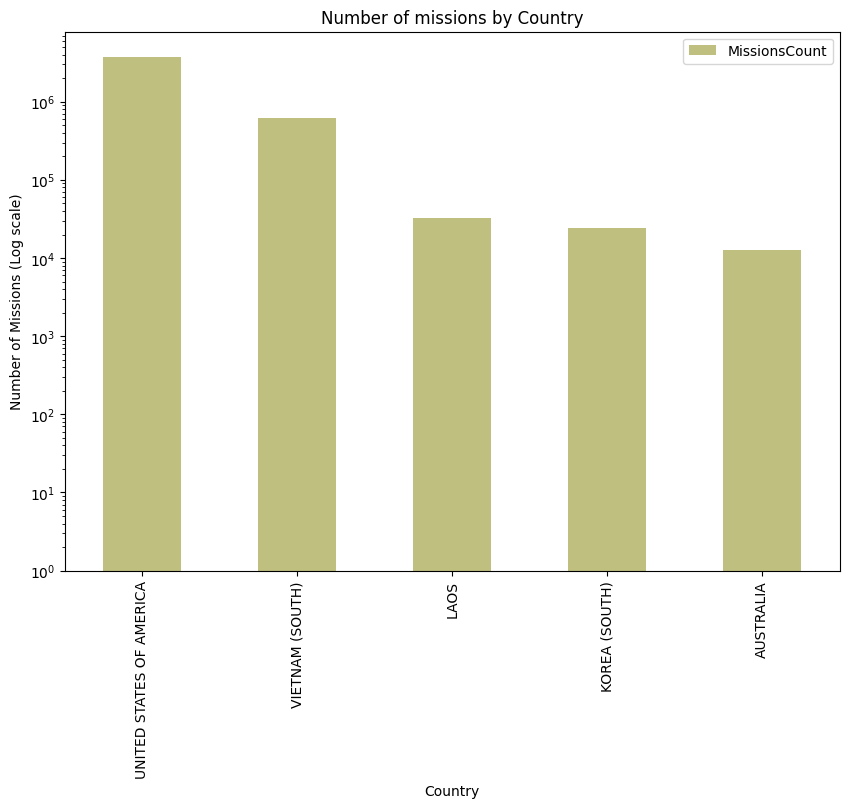

In [25]:
pl = missions_count_pd.plot(kind="bar",
                            x="ContryFlyingMission", y="MissionsCount",
                            figsize=(10, 7), log=True, alpha=0.5, color="olive")
pl.set_xlabel("Country")
pl.set_ylabel("Number of Missions (Log scale)")
pl.set_title("Number of missions by Country")

----

## Questions 2: Show the number of missions in time for each of the countries involved.

Keywords: `group by`, `parse date`, `plot`

Let's select the relevant columns:

In [26]:
missions_countries = Bombing_Operations.selectExpr(["to_date(MissionDate) as MissionDate", "ContryFlyingMission"])
missions_countries

DataFrame[MissionDate: date, ContryFlyingMission: string]

The filed MissionDate is converted to a Python `date` object.

Now we can group by `MissionDate` and `ContryFlyingMission` to get the count:

In [27]:
missions_by_date = missions_countries\
                    .groupBy(["MissionDate", "ContryFlyingMission"])\
                    .agg(count("*").alias("MissionsCount"))\
                    .sort(asc("MissionDate")).toPandas()
missions_by_date.head()

,MissionDate,ContryFlyingMission,MissionsCount
0,1965-10-01,UNITED STATES OF AMERICA,447
1,1965-10-02,UNITED STATES OF AMERICA,652
2,1965-10-03,UNITED STATES OF AMERICA,608
3,1965-10-04,UNITED STATES OF AMERICA,532
4,1965-10-05,UNITED STATES OF AMERICA,697


Now we can plot the content with a different series for each country:

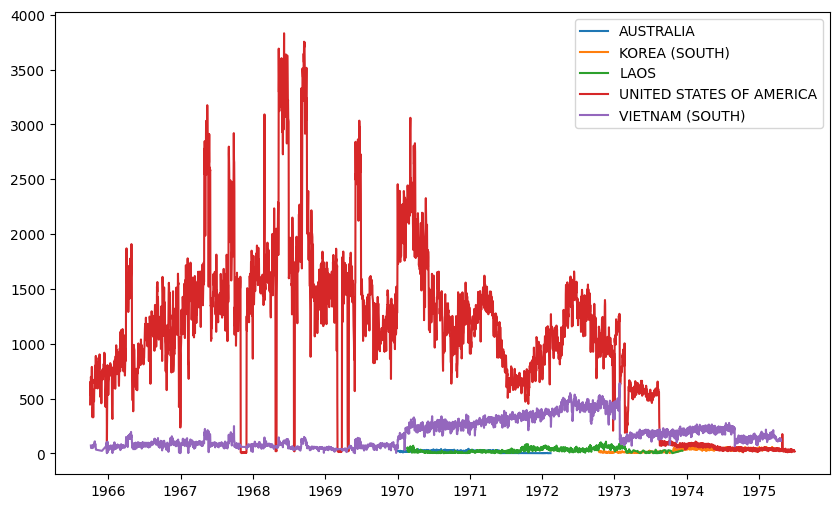

In [28]:
fig = plt.figure(figsize=(10, 6))

# iterate the different groups to create a different series
for country, missions in missions_by_date.groupby("ContryFlyingMission"):
    plt.plot(missions["MissionDate"], missions["MissionsCount"], label=country)

plt.legend(loc='best')

We can observe how South Vietnam increased its missions starting from 1970. The drop in 1973 is motivated by the [Paris Peace Accords](https://en.wikipedia.org/wiki/Paris_Peace_Accords) that took place on January 27th, 1973, to establish peace in Vietnam and end the war.

----

## Question 3: Who bombed this location?

Keywords: `RDD map reduce` `cache` `save results`

In [29]:
jun_29_operations = Bombing_Operations.where("MissionDate = '1966-06-29' AND TargetCountry='NORTH VIETNAM'")

Which coutries scheduled missions that day?

In [30]:
jun_29_operations.groupBy("ContryFlyingMission").agg(count("*").alias("MissionsCount")).toPandas()

,ContryFlyingMission,MissionsCount
0,VIETNAM (SOUTH),6
1,UNITED STATES OF AMERICA,389


Most of the operation that day were performed by USA airplanes.

In [31]:
jun_29_operations.take(1)

[Row(AirCraft='F-105', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1966-06-29', OperationSupported='STEEL TIGER', PeriodOfDay='D', TakeoffLocation='TAKHLI', TargetCountry='NORTH VIETNAM', TimeOnTarget=310.0, WeaponType='1000LB MK-83', WeaponsLoadedWeight=-1)]

You can specify to cache the content in memory:

In [32]:
jun_29_operations.cache()

DataFrame[AirCraft: string, ContryFlyingMission: string, MissionDate: string, OperationSupported: string, PeriodOfDay: string, TakeoffLocation: string, TargetCountry: string, TimeOnTarget: double, WeaponType: string, WeaponsLoadedWeight: bigint]

Now you can count the number of rows and move the content to the cache:

In [33]:
%time jun_29_operations.count()

CPU times: user 3.15 ms, sys: 189 µs, total: 3.34 ms
Wall time: 10.6 s


395

The second time the content is cached and the operation is much faster:

In [34]:
%time jun_29_operations.count()

CPU times: user 695 µs, sys: 0 ns, total: 695 µs
Wall time: 174 ms


395

You can also save the results on a file...

In [35]:
jun_29_operations.write.mode('overwrite').json("jun_29_operations.json")

... and read from the file:

In [36]:
jun_29_operations = spark.read.json("jun_29_operations.json")

We can use the simple DataFrame API...

In [37]:
TakeoffLocationCounts = jun_29_operations\
                            .groupBy("TakeoffLocation").agg(count("*").alias("MissionsCount"))\
                            .sort(desc("MissionsCount"))
TakeoffLocationCounts.show()

+----------------+-------------+
| TakeoffLocation|MissionsCount|
+----------------+-------------+
|   CONSTELLATION|           87|
|          TAKHLI|           56|
|           KORAT|           55|
|        UDORN AB|           44|
|         UBON AB|           44|
|          DANANG|           35|
|          RANGER|           35|
|    TAN SON NHUT|           26|
|HANCOCK (CVA-19)|           10|
|    CAM RANH BAY|            2|
|         CUBI PT|            1|
+----------------+-------------+



... or the explicit Map/Reduce format with RDDs.

First we emit a pair in the format (Location, 1):

In [38]:
all_locations = jun_29_operations.rdd.map(lambda row: (row.TakeoffLocation, 1))
all_locations.take(3)

[('TAKHLI', 1), ('DANANG', 1), ('CONSTELLATION', 1)]

Then, we sum counters in the reduce step, and we sort by count:

In [39]:
locations_counts_rdd = all_locations.reduceByKey(lambda a, b: a+b).sortBy(lambda r: -r[1])
locations_counts_rdd.take(3)

[('CONSTELLATION', 87), ('TAKHLI', 56), ('KORAT', 55)]

Now we can convert the RDD in dataframe by mapping the pairs to objects of type `Row`

In [40]:
locations_counts_with_schema = locations_counts_rdd.map(lambda r: Row(TakeoffLocation=r[0], MissionsCount=r[1]))
locations_counts = spark.createDataFrame(locations_counts_with_schema)
locations_counts.show()

+----------------+-------------+
| TakeoffLocation|MissionsCount|
+----------------+-------------+
|   CONSTELLATION|           87|
|          TAKHLI|           56|
|           KORAT|           55|
|         UBON AB|           44|
|        UDORN AB|           44|
|          DANANG|           35|
|          RANGER|           35|
|    TAN SON NHUT|           26|
|HANCOCK (CVA-19)|           10|
|    CAM RANH BAY|            2|
|         CUBI PT|            1|
+----------------+-------------+



<img style="float: right;" src="https://raw.githubusercontent.com/epfl-ada/2019/c17af0d3c73f11cb083717b7408fedd86245dc4d/Tutorials/04%20-%20Scaling%20Up/img/USS_Constellation.jpg">


That day the most common take-off location was the ship USS Constellation (CV-64). We cannot univocally identify one take off location, but we can reduce the possible candidates. Next steps: explore TimeOnTarget feature.

_USS Constellation (CV-64), a Kitty Hawk-class supercarrier, was the third ship of the United States Navy to be named in honor of the "new constellation of stars" on the flag of the United States. One of the fastest ships in the Navy, as proven by her victory during a battlegroup race held in 1985, she was nicknamed "Connie" by her crew and officially as "America's Flagship"._

----

## Questions 4: What is the most used aircraft type (number of missions)?

Keywords: `join` `group by`

Let's check the content of `Aircraft_Glossary`:

In [41]:
Aircraft_Glossary.show(5)

+--------+--------------------+--------------------+
|AirCraft|        AirCraftName|        AirCraftType|
+--------+--------------------+--------------------+
|     A-1|Douglas A-1 Skyra...|         Fighter Jet|
|    A-26|Douglas A-26 Invader|        Light Bomber|
|    A-37|Cessna A-37 Drago...|Light ground-atta...|
|     A-4|McDonnell Douglas...|         Fighter Jet|
|     A-5|North American A-...|          Bomber Jet|
+--------+--------------------+--------------------+
only showing top 5 rows


We are interested in the filed `AirCraftType`.

In [42]:
Bombing_Operations.select("AirCraft").show(5)

+--------+
|AirCraft|
+--------+
|   EC-47|
|   EC-47|
|    RF-4|
|     A-1|
|    A-37|
+--------+
only showing top 5 rows


We can join on the column `AirCraft` of both dataframes.

With Dataframe API:

In [43]:
missions_joined = Bombing_Operations.join(Aircraft_Glossary,
                                          Bombing_Operations.AirCraft == Aircraft_Glossary.AirCraft)
missions_joined

DataFrame[AirCraft: string, ContryFlyingMission: string, MissionDate: string, OperationSupported: string, PeriodOfDay: string, TakeoffLocation: string, TargetCountry: string, TimeOnTarget: double, WeaponType: string, WeaponsLoadedWeight: bigint, AirCraft: string, AirCraftName: string, AirCraftType: string]

We can select only the field we are interested in:

In [44]:
missions_aircrafts = missions_joined.select("AirCraftType")
missions_aircrafts.show(5)

+--------------------+
|        AirCraftType|
+--------------------+
|Military Transpor...|
|Military Transpor...|
|  Fighter bomber jet|
|         Fighter Jet|
|Light ground-atta...|
+--------------------+
only showing top 5 rows


And finally we can group by `AirCraftType` and count:

In [45]:
missions_aircrafts.groupBy("AirCraftType").agg(count("*").alias("MissionsCount"))\
                  .sort(desc("MissionsCount"))\
                  .show()

+--------------------+-------------+
|        AirCraftType|MissionsCount|
+--------------------+-------------+
|  Fighter Jet Bomber|      1073126|
|         Fighter Jet|       882594|
|  Jet Fighter Bomber|       451385|
|     Attack Aircraft|       315246|
|Light ground-atta...|       267457|
|  Fighter bomber jet|       242231|
|Military Transpor...|       228426|
|  Utility Helicopter|       146653|
|    Strategic bomber|        99100|
|     Tactical Bomber|        82219|
|Observation Aircraft|        81820|
|Fixed wing ground...|        75058|
|Ground attack air...|        73843|
|Carrier-based Fig...|        58691|
|   Training Aircraft|        48435|
|       Light fighter|        39999|
|        Light Bomber|        39262|
|Light Tactical Bo...|        34738|
| Light Utility Plane|        28582|
|Observation/ Ligh...|        24491|
+--------------------+-------------+
only showing top 20 rows


In alternative we can rewrite this in pure SQL:

In [46]:
Bombing_Operations.createOrReplaceTempView("Bombing_Operations")
Aircraft_Glossary.createOrReplaceTempView("Aircraft_Glossary")

query = """
SELECT AirCraftType, count(*) MissionsCount
FROM Bombing_Operations bo
JOIN Aircraft_Glossary ag
ON bo.AirCraft = ag.AirCraft
GROUP BY AirCraftType
ORDER BY MissionsCount DESC
"""

spark.sql(query).show()

+--------------------+-------------+
|        AirCraftType|MissionsCount|
+--------------------+-------------+
|  Fighter Jet Bomber|      1073126|
|         Fighter Jet|       882594|
|  Jet Fighter Bomber|       451385|
|     Attack Aircraft|       315246|
|Light ground-atta...|       267457|
|  Fighter bomber jet|       242231|
|Military Transpor...|       228426|
|  Utility Helicopter|       146653|
|    Strategic bomber|        99100|
|     Tactical Bomber|        82219|
|Observation Aircraft|        81820|
|Fixed wing ground...|        75058|
|Ground attack air...|        73843|
|Carrier-based Fig...|        58691|
|   Training Aircraft|        48435|
|       Light fighter|        39999|
|        Light Bomber|        39262|
|Light Tactical Bo...|        34738|
| Light Utility Plane|        28582|
|Observation/ Ligh...|        24491|
+--------------------+-------------+
only showing top 20 rows


The aircrafts of type `Fighter Jet Bomber` participated in most of the missions.

Note: This dataset would require further cleaning and normalization. See `Fighter Jet Bomber`, `Jet Fighter Bomber`, `Fighter bomber jet`